In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices
from statsmodels.stats.multitest import multipletests
from scipy import stats
from tableone import TableOne
# Hide annoying ipykernel warnings
import warnings;
warnings.filterwarnings('ignore');

# Day and Night HbA1c

In [2]:
# Import data - run GitHub/BDC-Code/Viral Shah/Day and Night CGM/clean_cgms.py first
wd = '/Users/timvigers/Dropbox/Work/Viral Shah/Day and Night CGM/'
df = pd.read_csv(wd+'Data_Clean/analysis_dataset.csv')

# Data Characteristics

- Participants with no CGM data 2 weeks prior to most recent HbA1c were removed.
- Several participants' CGM files did not contain glucose data.
- Mean glucose was used in place of AUC because participants did not always have the exact same number of day and night observations, and night was defined as only 7 hours long compared to 17 hours of daytime. Mean glucose and AUC per hour are essentially equivalent.

## Table 1

In [3]:
cgm_vars = ['14 Day Mean','14 Day TIR','14 Night Mean','14 Night TIR',
            '30 Day Mean','30 Day TIR','30 Night Mean','30 Night TIR',
            '60 Day Mean','60 Day TIR','60 Night Mean','60 Night TIR',
            '90 Day Mean','90 Day TIR','90 Night Mean','90 Night TIR']
cols = ['Gender','Insulin','Age','HbA1c']+cgm_vars
# Print
t1 = TableOne(df,columns=cols)
t1

Missing       Overall
n                                                       280
Gender, n (%)            F                  0    157 (56.1)
                         M                       123 (43.9)
Insulin, n (%)           Insulin Pump      11    149 (55.4)
                         MDI/Ratio               120 (44.6)
Age, mean (SD)                              0   41.5 (13.6)
HbA1c, mean (SD)                            0     7.1 (1.4)
14 Day Mean, mean (SD)                      0  163.8 (36.0)
14 Day TIR, mean (SD)                       0   61.4 (19.5)
14 Night Mean, mean (SD)                    0  167.4 (42.0)
14 Night TIR, mean (SD)                     0   59.2 (22.6)
30 Day Mean, mean (SD)                      0  164.8 (35.3)
30 Day TIR, mean (SD)                       0   61.0 (19.3)
30 Night Mean, mean (SD)                    0  166.4 (39.2)
30 Night TIR, mean (SD)                     0   59.9 (21.3)
60 Day Mean, mean (SD)                      0  164.5 (34.4)
60 Day TIR, mean (SD)                       0   61.2 (18.8)
60 Night Mean, mean (SD)                    0  165.5 (37.8)
60 Night TIR, mean (SD)                     0   60.2 (20.1)
90 Day Mean, mean (SD)                      0  164.3 (34.0)
90 Day TIR, mean (SD)                       0   61.4 (18.4)
90 Night Mean, mean (SD)                    0  165.3 (37.9)
90 Night TIR, mean (SD)                     0   60.4 (20.2)

## Variable Plots

All variables appear to be reasonably Gaussian, although this is not a requirement for Pearson's correlation anyway.

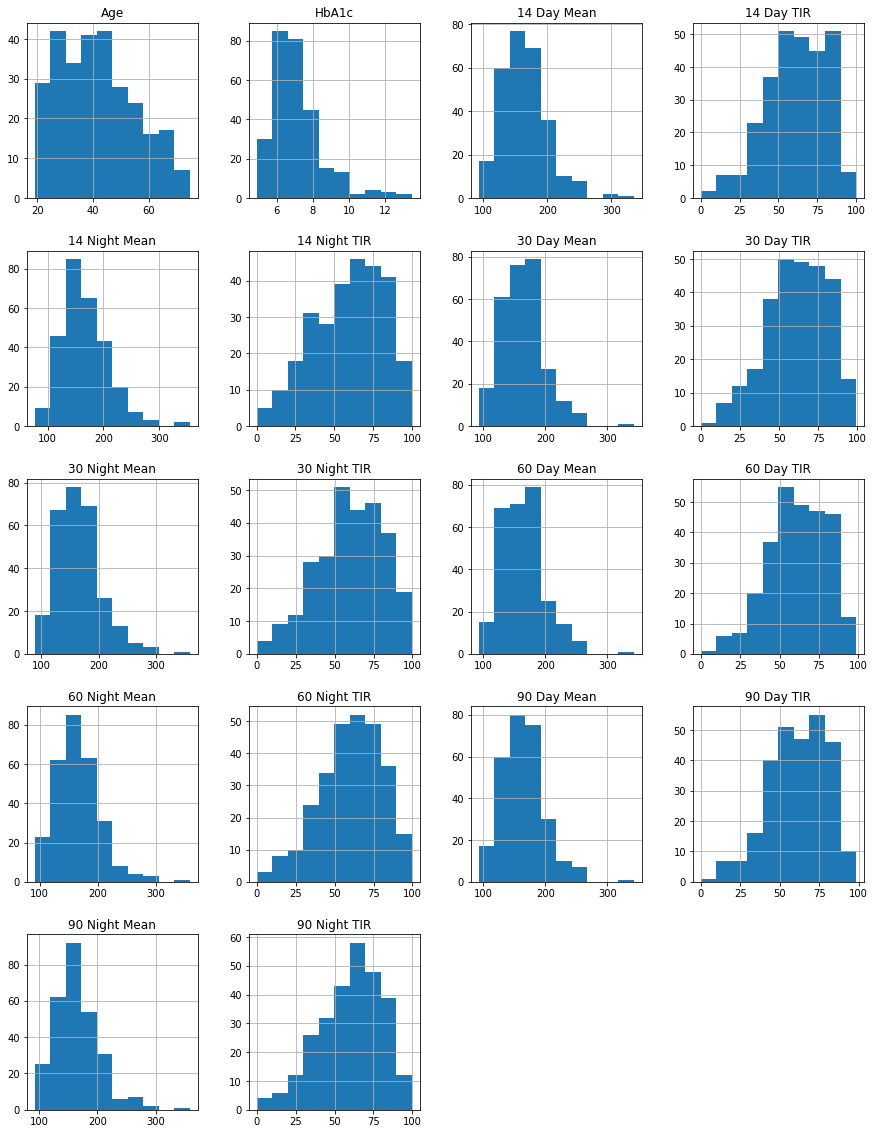

In [4]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df.hist(ax = ax);# Semicolon hides the matplotlib descriptions in Jupyter

# Correlation with HbA1c

All following p values were FDR-adjusted for multiple comparisons.

## Full Cohort

All CGM metrics were significantly correlated with HbA1c. Correlations were not as strong for nighttime variables. Correlation between mean glucose and HbA1c was slightly better than the correlation between TIR and HbA1c, but generally they seem to be comparable.

In [5]:
# Correlation for each CGM variable with HbA1c
res = {"Correlation":[],"p":[]}
for v in cgm_vars:
    res['Correlation'].append(stats.pearsonr(x = df[v],y = df['HbA1c'])[0])
    res['p'].append(stats.pearsonr(x = df[v],y = df['HbA1c'])[1])
res=pd.DataFrame(data=res)
res.index = cgm_vars
# Adjust p values
res['p'] = multipletests(res['p'],alpha=0.05,method='fdr_bh')[1]
# Format
res['p'] = ["< 0.001" if p < 0.001 else p for p in res['p']]
res['Correlation'] = round(res['Correlation'],3)
res

,Correlation,p
14 Day Mean,0.842,< 0.001
14 Day TIR,-0.816,< 0.001
14 Night Mean,0.772,< 0.001
14 Night TIR,-0.707,< 0.001
30 Day Mean,0.854,< 0.001
30 Day TIR,-0.829,< 0.001
30 Night Mean,0.795,< 0.001
30 Night TIR,-0.744,< 0.001
60 Day Mean,0.857,< 0.001
60 Day TIR,-0.844,< 0.001


## Stratified by HbA1c Group

Participants were grouped into three HbA1c categories: < 7%, 7.1-8.5% and > 8.5%:

In [46]:
# Categorize HbA1c
df['HbA1c Group'] = pd.cut(df['HbA1c'],[0,7,8.5,20],labels=['< 7%','7-8.5%','> 8.5%'])
display(pd.DataFrame(df['HbA1c Group'].value_counts()))

,HbA1c Group
< 7%,153
7-8.5%,94
> 8.5%,33


In [41]:
# Model formula
for g in df['HbA1c Group'].unique():
    res = {"Correlation":[],"p":[]}
    df_cat = df.loc[df['HbA1c Group'] == g]
    for v in cgm_vars:
        res['Correlation'].append(stats.pearsonr(x = df_cat[v],y = df_cat['HbA1c'])[0])
        res['p'].append(stats.pearsonr(x = df_cat[v],y = df_cat['HbA1c'])[1])
    res=pd.DataFrame(data=res)
    res.index = cgm_vars
    # Adjust p values
    res['p'] = multipletests(res['p'],alpha=0.05,method='fdr_bh')[1]
    # Format
    res['p'] = ["< 0.001" if p < 0.001 else p for p in res['p']]
    res['Correlation'] = round(res['Correlation'],3)
    print('HbA1c group: '+g)
    display(pd.DataFrame(res))

HbA1c group: < 7%


,Correlation,p
14 Day Mean,0.703,< 0.001
14 Day TIR,-0.593,< 0.001
14 Night Mean,0.597,< 0.001
14 Night TIR,-0.464,< 0.001
30 Day Mean,0.703,< 0.001
30 Day TIR,-0.589,< 0.001
30 Night Mean,0.609,< 0.001
30 Night TIR,-0.493,< 0.001
60 Day Mean,0.709,< 0.001
60 Day TIR,-0.605,< 0.001


HbA1c group: 7-8.5%


,Correlation,p
14 Day Mean,0.460,< 0.001
14 Day TIR,-0.419,< 0.001
14 Night Mean,0.161,0.122221
14 Night TIR,-0.171,0.106813
30 Day Mean,0.565,< 0.001
30 Day TIR,-0.547,< 0.001
30 Night Mean,0.277,0.007855
30 Night TIR,-0.295,0.004733
60 Day Mean,0.567,< 0.001
60 Day TIR,-0.557,< 0.001


HbA1c group: > 8.5%


,Correlation,p
14 Day Mean,0.620,< 0.001
14 Day TIR,-0.635,< 0.001
14 Night Mean,0.497,0.005743
14 Night TIR,-0.331,0.063613
30 Day Mean,0.634,< 0.001
30 Day TIR,-0.673,< 0.001
30 Night Mean,0.475,0.008272
30 Night TIR,-0.410,0.022051
60 Day Mean,0.598,< 0.001
60 Day TIR,-0.672,< 0.001
